In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
DATAPATH2 = configs["DATAPATH2"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/figures/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


## Load data (view, subscribe, comment + survey)

In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all[["respondent_id","channel_id","video_id","timestamp"]]
# view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id"]] # do not dropna 
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

## Trim the time period 

In [3]:
pol_df = pd.read_csv(DATAPATH + "survey/pol_survey_cleaned_NEW_INCLUDEALL.csv").rename(columns={"user_id":"respondent_id"})
pol_df.drop(columns=["weight"], inplace=True)
new_weights = pd.read_spss(DATAPATH + "survey/TK_DataDonation_eng.sav")[["respondent_id","weight"]]
new_weights["respondent_id"] = new_weights["respondent_id"].map(lambda x: int(x))
pol_df = pol_df.merge(new_weights, on="respondent_id", how="left")
print("total number of respondents:", len(pol_df))

total number of respondents: 758


## Load labels

In [4]:
# load all political channel 
cols = ["channel_id", "upload_id", "topics_str"]
channel_info = pd.read_pickle(DATAPATH2 + "clean/channel-info-042624.pkl")[cols].dropna(subset="topics_str")

# get a list of political videos and channels that have uploaded political videos
pol_videos = pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["video_id"].tolist()
pol_videos_ch = set(pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["channel_id"].tolist())

CHANNEL_CATG = "Politics"
pol_channels = channel_info[channel_info["topics_str"].str.contains(CHANNEL_CATG)]["channel_id"].tolist()
pol_channels = set(pol_channels).union(pol_videos_ch)
print("# of political channels:", len(set(pol_channels)))  # 11346

# of political channels: 11346


In [5]:
channel_labels_hu = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_hu

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_hu[channel_labels_hu[label_col].isin(LABEL_MAP.keys())]

print("number of neutral, anti-gov, pro-gov channels:",)
CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print("label:", val, "\t# of channels:", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"] = {"before":-1, "after":1} 

number of neutral, anti-gov, pro-gov channels:
label: 0 	# of channels: 149
label: -1 	# of channels: 276
label: 1 	# of channels: 139


## Extract user groups

In [6]:
pol_view = view_all[view_all["channel_id"].isin(pol_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(pol_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(pol_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(pol_channels)].copy()


In [7]:
hupol_channels = CHANNEL_LABEL_MAP.keys()
hupol_view = view_all[view_all["channel_id"].isin(hupol_channels)].copy()
hupol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(hupol_channels)].copy()
hupol_comment = comment_all[comment_all["channel_id"].isin(hupol_channels)].copy()
hupol_comment_public = comment_public[comment_public["channel_id"].isin(hupol_channels)].copy()

uall = set(pol_df["respondent_id"].tolist())
uytb = set(view_all["respondent_id"].tolist()).union(set(subscribe_all["respondent_id"].tolist())).union(set(comment_all["respondent_id"].tolist()))
upol = set(pol_view["respondent_id"].tolist()).union(set(pol_subscribe["respondent_id"].tolist())).union(set(pol_comment["respondent_id"].tolist()))
uhup = set(hupol_view["respondent_id"].tolist()).union(set(hupol_subscribe["respondent_id"].tolist())).union(set(hupol_comment["respondent_id"].tolist()))

uv = set(hupol_view["respondent_id"].tolist())
us = set(hupol_subscribe["respondent_id"].tolist())
uc = set(hupol_comment["respondent_id"].tolist())

# here we prepare two sets of user groups (4 for mainbody figures and 7 for appendix figures)
# 4 groups
UGROUPS_4 = [uall, uv, us, uc]
UGROUPS_LAB_4 = ["All", "View", "Subscribe", "Comment"]
# 7 groups
UGROUPS_7 = [uall, uytb, upol, uhup, uv, us, uc]
UGROUPS_LAB_7 = ["ALL", "YTB", "POL", "POL-HU", "VIEW", "SBSC", "CMNT"]

### Figure 1

Distributions of respondent positions along the anti-/pro-government scale for four respondent groups (i.e., the entire sample, viewers, subscribers, and commenters)

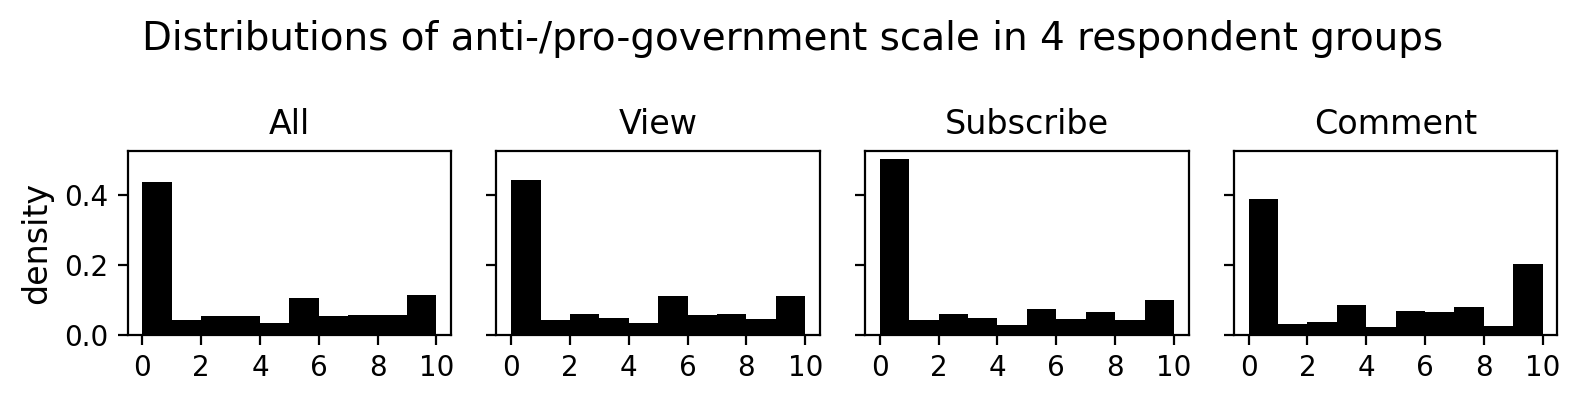

In [8]:
fig,axes = plt.subplots(ncols=4, figsize=(8,2), sharey=True)

varname = "feel_thm_fdsz"
varname_display = "Distributions of anti-/pro-government scale in 4 respondent groups"

for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS_4, UGROUPS_LAB_4)):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    ax.hist(sub_df[varname], density=True, bins=10, color="black", weights=sub_df["weight"])
    ax.set_title(lab, fontsize=12)
    # ax.set_xticks([*range(1,8,2)], [*range(1,8,2)])
    ax.set_xticks([*range(0,12,2)], [*range(0,12,2)])
axes[0].set_ylabel("density", fontsize=12)
plt.suptitle(varname_display, fontsize=14)
plt.tight_layout()
# plt.savefig(OUTPATH + f"distribution-user-{varname}-diff-pol-activities-weighted-4grp.pdf", dpi=300, bbox_inches="tight")

### Appendeix Figure 7

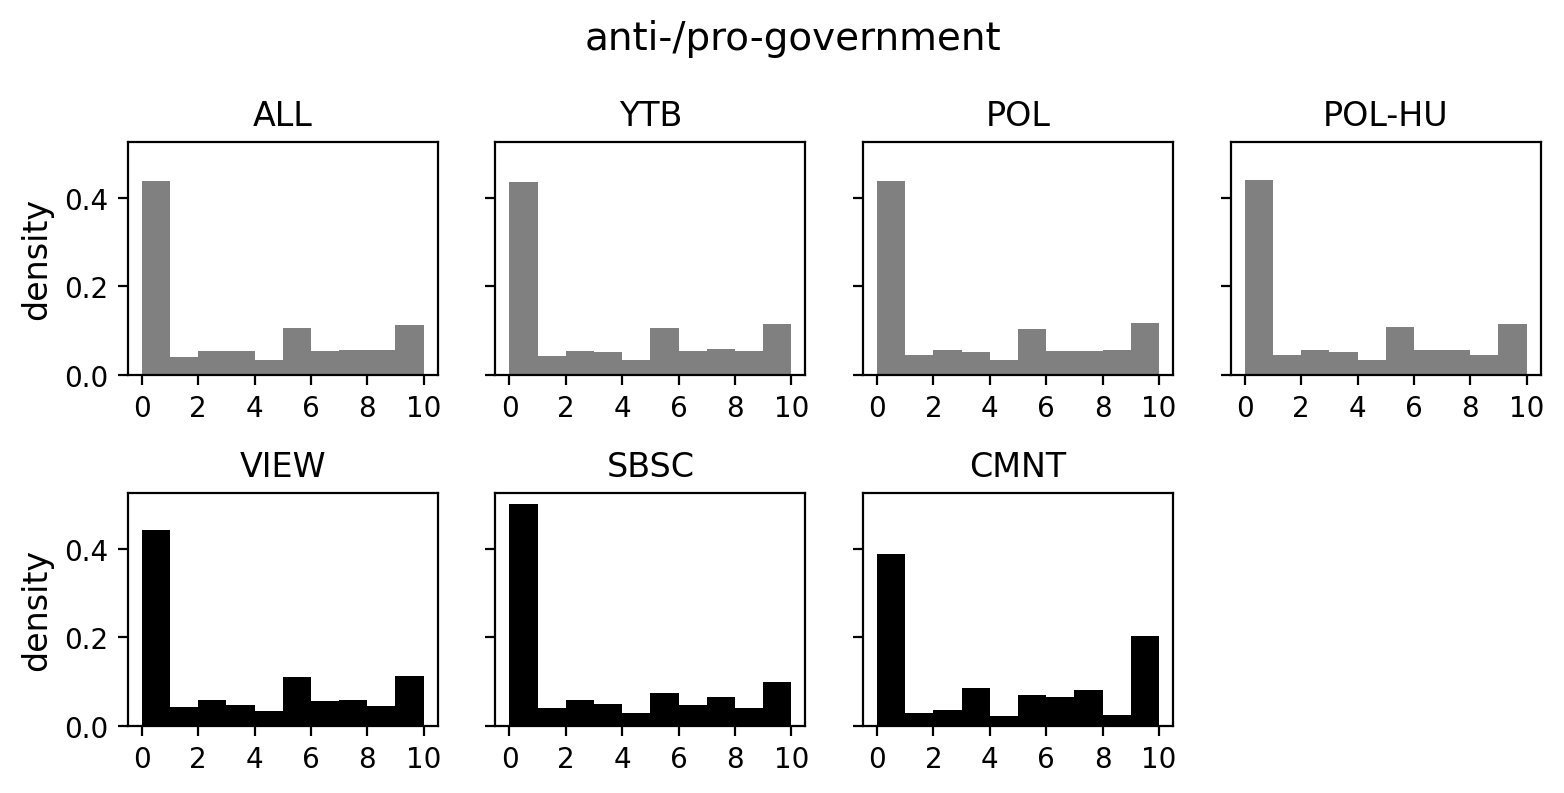

In [9]:
fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(8,4), sharey=True)
axes = [x for ls in axes for x in ls]

varname = "feel_thm_fdsz"
varname_display = "anti-/pro-government"

for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS_7, UGROUPS_LAB_7)):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    if i <= 3: 
        ax.hist(sub_df[varname], density=True, bins=10, color="grey", weights=sub_df["weight"])
    else:
        ax.hist(sub_df[varname], density=True, bins=10, color="black", weights=sub_df["weight"])
    ax.set_title(lab, fontsize=12)
    ax.set_xticks([*range(0,12,2)], [*range(0,12,2)])
for i in [0,4]:
    axes[i].set_ylabel("density", fontsize=12)
# axes[4].set_xlabel(varname_display, fontsize=12)
plt.suptitle(varname_display, fontsize=14)
plt.tight_layout()
axes[-1].set_visible(False)
# plt.savefig(OUTPATH + f"distribution-user-feel_thm_fdsz-diff-pol-activities-weighted.pdf", dpi=300, bbox_inches="tight")

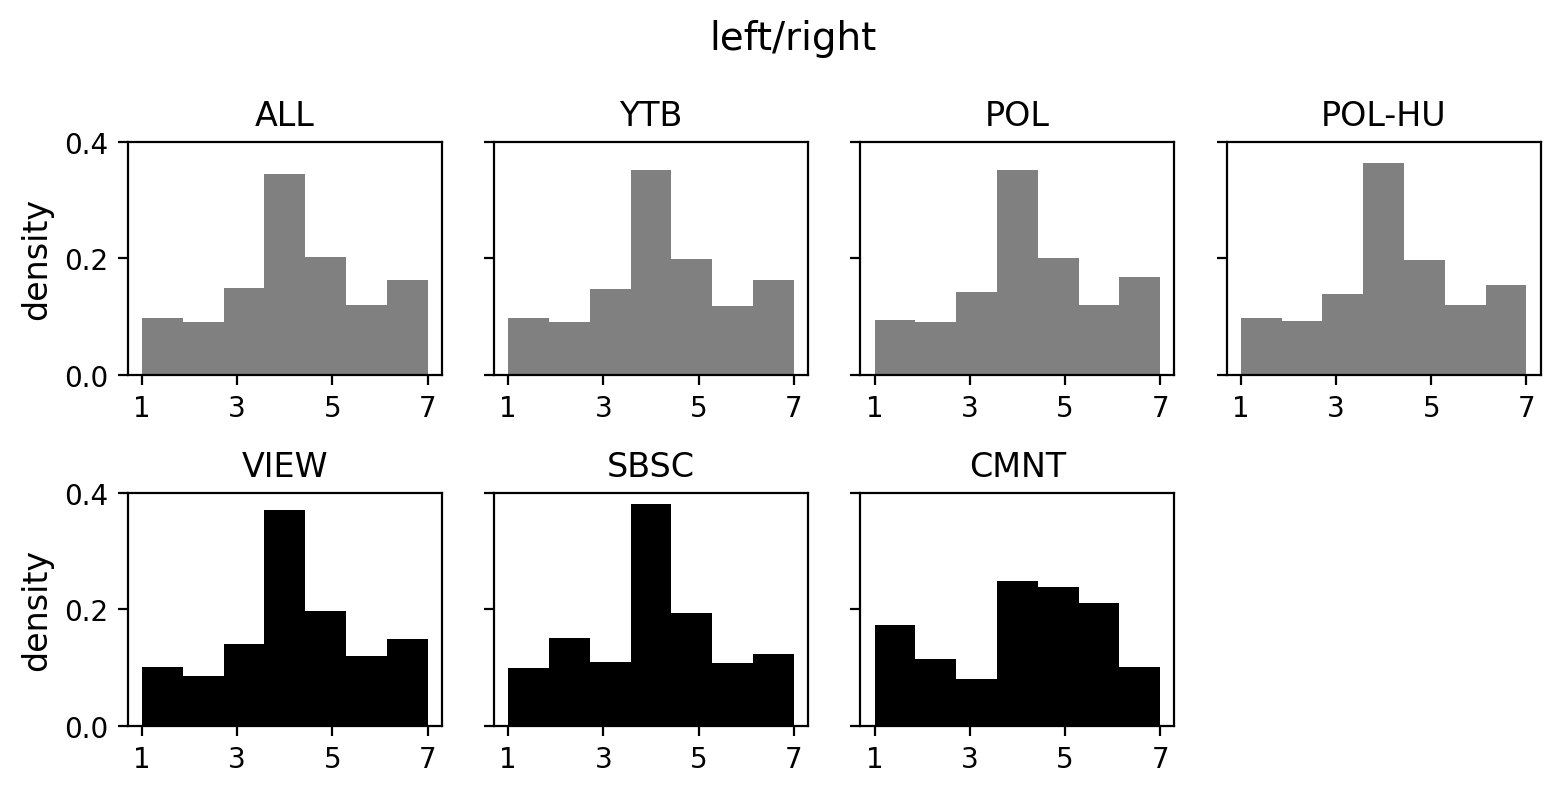

In [10]:
fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(8,4), sharey=True)
axes = [x for ls in axes for x in ls]

varname = "lftRght"
varname_display = "left/right"

for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS_7, UGROUPS_LAB_7)):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    if i <= 3: 
        ax.hist(sub_df[varname], density=True, bins=7, color="grey", weights=sub_df["weight"])
    else:
        ax.hist(sub_df[varname], density=True, bins=7, color="black", weights=sub_df["weight"])
    ax.set_title(lab, fontsize=12)
    ax.set_xticks([*range(1,8,2)], [*range(1,8,2)])
for i in [0,4]:
    axes[i].set_ylabel("density", fontsize=12)
plt.suptitle(varname_display, fontsize=14)
plt.tight_layout()
axes[-1].set_visible(False)
# plt.savefig(OUTPATH + f"distribution-user-lftRght-diff-pol-activities-weighted.pdf", dpi=300, bbox_inches="tight")

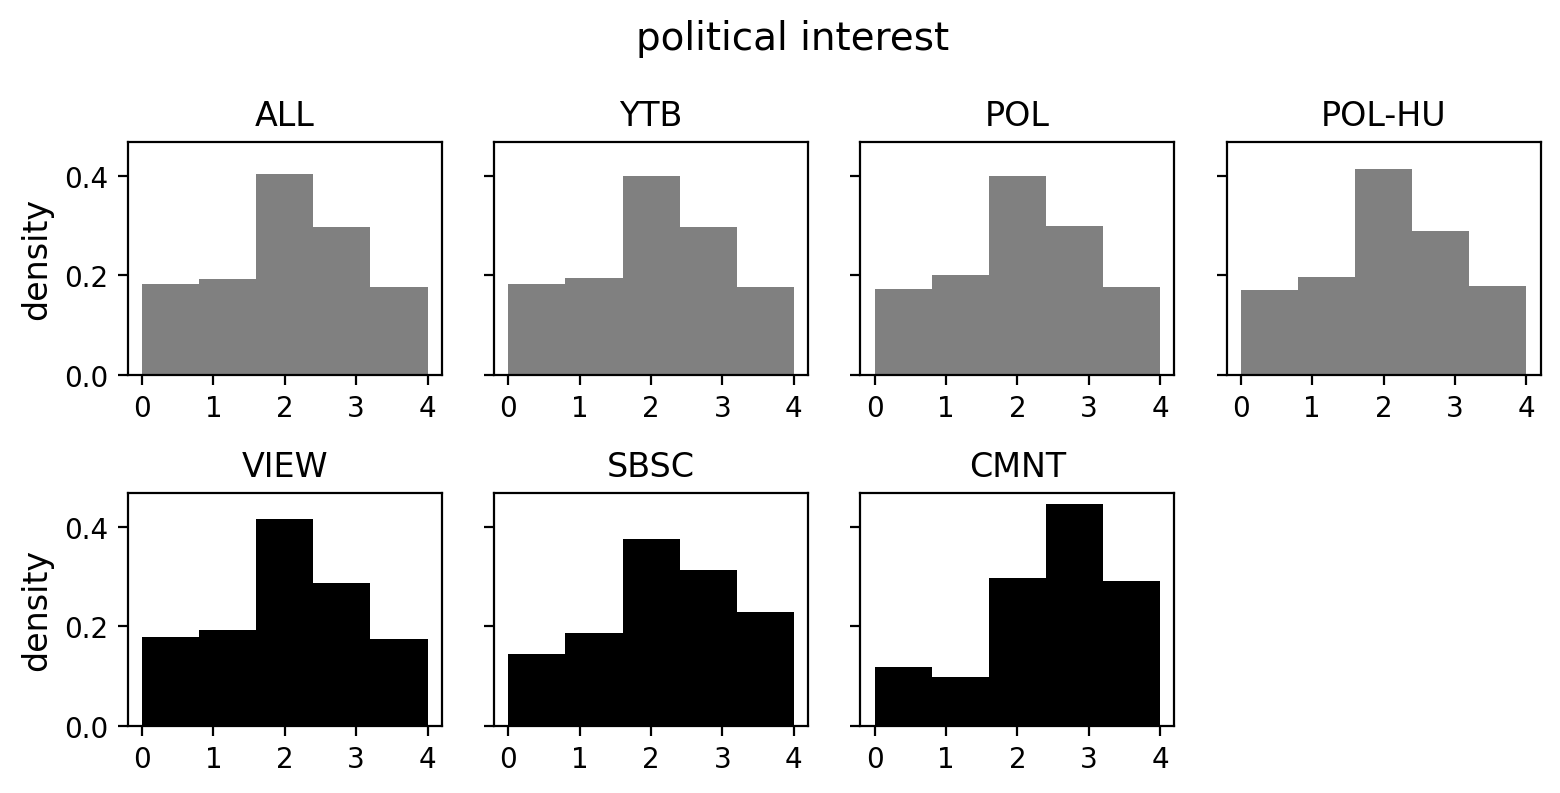

In [11]:
fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(8,4), sharey=True)
axes = [x for ls in axes for x in ls]

varname = "interest_politics"
varname_display = "political interest"

for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS_7, UGROUPS_LAB_7)):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    if i <= 3: 
        ax.hist(sub_df[varname], density=True, bins=5, color="grey", weights=sub_df["weight"])
    else:
        ax.hist(sub_df[varname], density=True, bins=5, color="black", weights=sub_df["weight"])
    ax.set_title(lab, fontsize=12)
    ax.set_xticks([*range(0,5,1)], [*range(0,5,1)])
for i in [0,4]:
    axes[i].set_ylabel("density", fontsize=12)
plt.suptitle(varname_display, fontsize=14)
plt.tight_layout()
axes[-1].set_visible(False)
# plt.savefig(OUTPATH + f"distribution-user-interest_politics-diff-pol-activities-weighted.pdf", dpi=300, bbox_inches="tight")

In [12]:
from scipy.stats import kurtosis

def compute_kurtosis(data):
    data = [d for d in data if str(d) != "nan"]
    if len(data) == 0:
        return np.NaN
    else:
        return kurtosis(data)

def compute_variance(data):
    data = [d for d in data if str(d) != "nan"]
    if len(data) == 0:
        return np.NaN
    else:
        return np.var(data)

### Figure 2
Variance and kurtosis of users’ anti-/pro-government scale across four respondent groups (i.e., the entire sample, viewers, subscribers, and commenters). 

Text(0.5, 1.07, 'Polarization measures for anti-/pro-government scale')

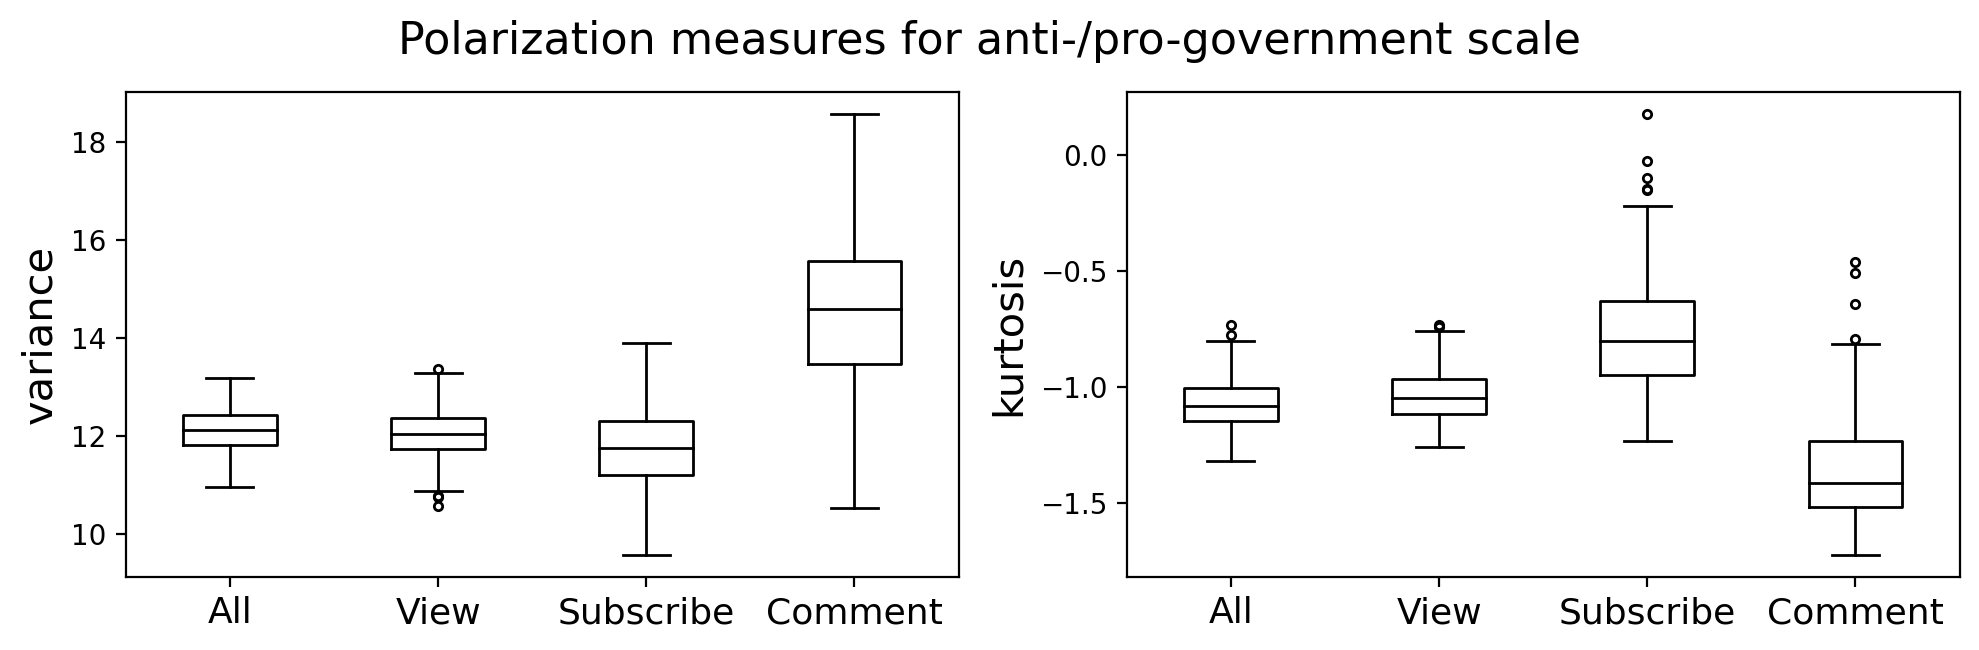

In [13]:
var = "feel_thm_fdsz"
nruns = 200
bp_data_var = {}
bp_data_kts = {}
for u,lab in zip(UGROUPS_4, UGROUPS_LAB_4):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    var_ls = []
    kts_ls = []
    for r in range(nruns):
        sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
        var_ls.append(compute_variance(sub_df_resample[var].tolist()))
        kts_ls.append(compute_kurtosis(sub_df_resample[var].tolist()))
    bp_data_var[lab] = var_ls
    bp_data_kts[lab] = kts_ls

fig,axes = plt.subplots(ncols=2, figsize=(10,3))
bp1 = axes[0].boxplot(bp_data_var.values(), sym=".")
axes[0].set_ylabel("variance", fontsize=15)
bp2 = axes[1].boxplot(bp_data_kts.values(), sym=".")
axes[1].set_ylabel("kurtosis", fontsize=15)

for i,bp in enumerate([bp1, bp2]):
    axes[i].set_xticks(range(1,len(UGROUPS_LAB_4)+1), UGROUPS_LAB_4, fontsize=13)
    for median in bp["medians"]:
        median.set_color("black")
plt.tight_layout()
plt.suptitle("Polarization measures for anti-/pro-government scale", fontsize=16, y=1.07)
# plt.savefig(OUTPATH + "variance_kurtosis_boxplot_antiPro_4grp.pdf", dpi=300, bbox_inches="tight")

### Appendix Figure 8

Text(0.5, 1.07, 'Polarization measures for anti-/pro-government scale')

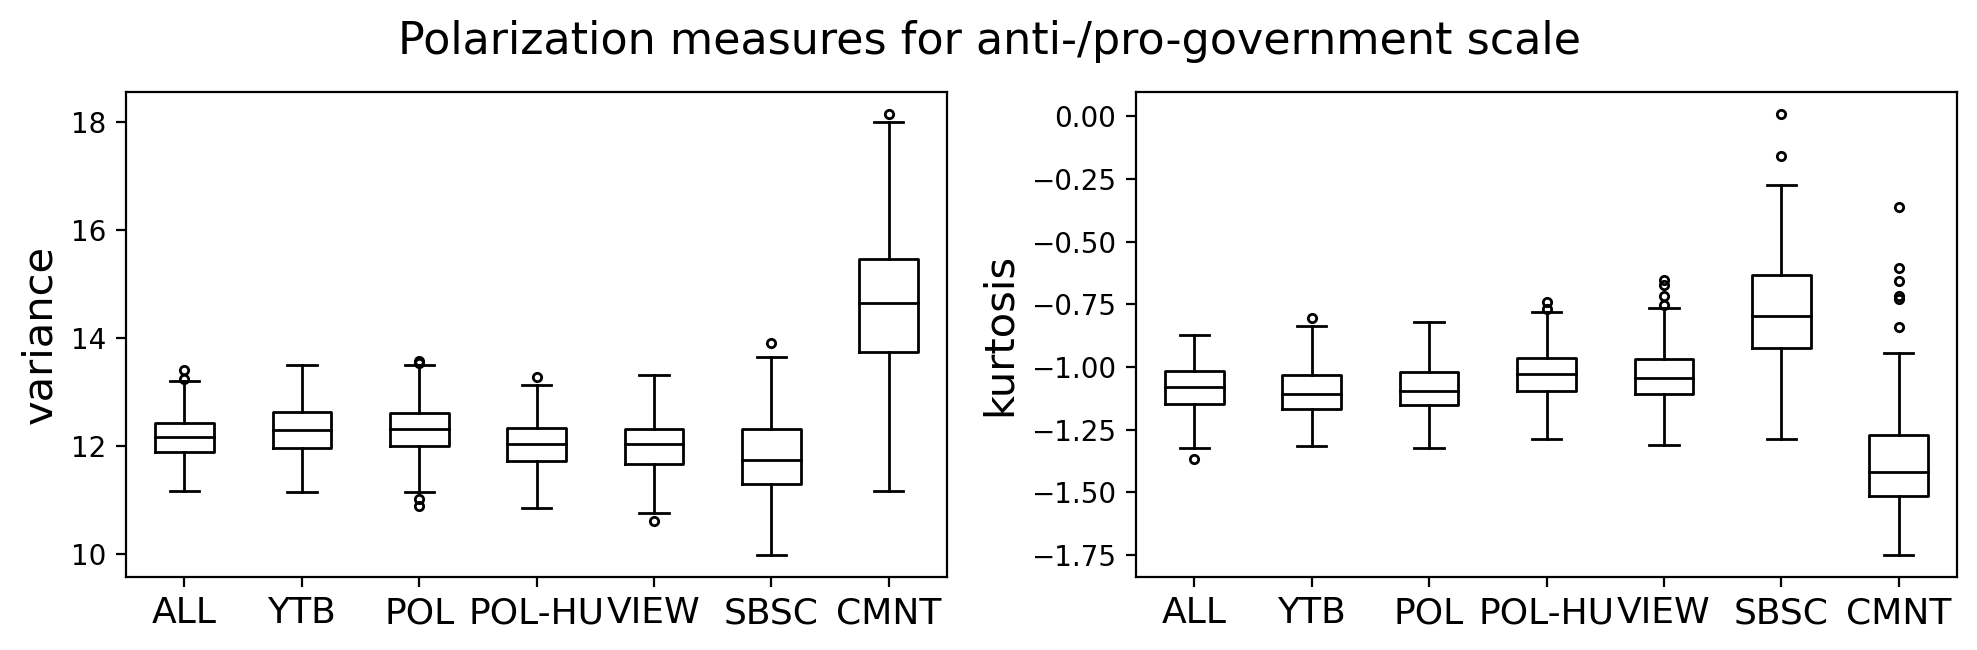

In [14]:
var = "feel_thm_fdsz"
nruns = 200
bp_data_var = {}
bp_data_kts = {}
for u,lab in zip(UGROUPS_7, UGROUPS_LAB_7):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    var_ls = []
    kts_ls = []
    for r in range(nruns):
        sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
        var_ls.append(compute_variance(sub_df_resample[var].tolist()))
        kts_ls.append(compute_kurtosis(sub_df_resample[var].tolist()))
    bp_data_var[lab] = var_ls
    bp_data_kts[lab] = kts_ls

fig,axes = plt.subplots(ncols=2, figsize=(10,3))
bp1 = axes[0].boxplot(bp_data_var.values(), sym=".")
axes[0].set_ylabel("variance", fontsize=15)
bp2 = axes[1].boxplot(bp_data_kts.values(), sym=".")
axes[1].set_ylabel("kurtosis", fontsize=15)

for i,bp in enumerate([bp1, bp2]):
    axes[i].set_xticks(range(1,len(UGROUPS_LAB_7)+1), UGROUPS_LAB_7, fontsize=13)
    for median in bp["medians"]:
        median.set_color("black")
plt.tight_layout()
plt.suptitle("Polarization measures for anti-/pro-government scale", fontsize=16, y=1.07)
# plt.savefig(OUTPATH + "variance_kurtosis_boxplot_antiPro_7grp.pdf", dpi=300, bbox_inches="tight")

Text(0.5, 1.07, 'Polarization measures for left/right scale')

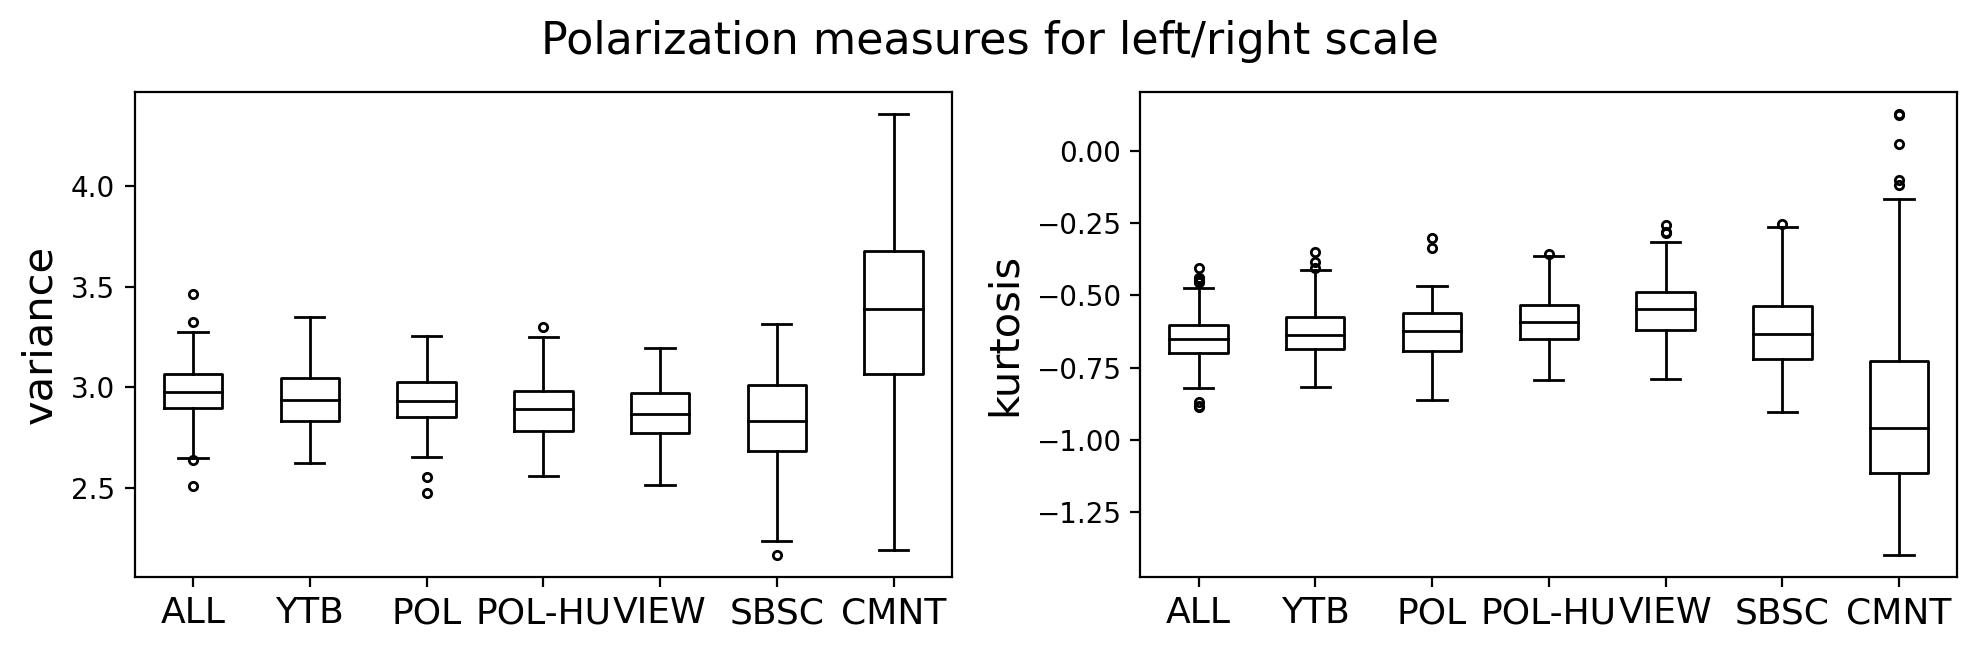

In [15]:
var = "lftRght"
nruns = 200
bp_data_var = {}
bp_data_kts = {}
for u,lab in zip(UGROUPS_7, UGROUPS_LAB_7):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    var_ls = []
    kts_ls = []
    for r in range(nruns):
        sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
        var_ls.append(compute_variance(sub_df_resample[var].tolist()))
        kts_ls.append(compute_kurtosis(sub_df_resample[var].tolist()))
    bp_data_var[lab] = var_ls
    bp_data_kts[lab] = kts_ls

fig,axes = plt.subplots(ncols=2, figsize=(10,3))
bp1 = axes[0].boxplot(bp_data_var.values(), sym=".")
axes[0].set_ylabel("variance", fontsize=15)
bp2 = axes[1].boxplot(bp_data_kts.values(), sym=".")
axes[1].set_ylabel("kurtosis", fontsize=15)

for i,bp in enumerate([bp1, bp2]):
    axes[i].set_xticks(range(1,len(UGROUPS_LAB_7)+1), UGROUPS_LAB_7, fontsize=13)
    for median in bp["medians"]:
        median.set_color("black")
plt.tight_layout()
plt.suptitle("Polarization measures for left/right scale", fontsize=16, y=1.07)
# plt.savefig(OUTPATH + "variance_kurtosis_boxplot_lftRght_7grp.pdf", dpi=300, bbox_inches="tight")

## Compare user-level selective exposure patterns

In [16]:
aggr_func1 = {"channel_id_time": lambda x: list(x)}
aggr_func2 = {"channel_id":lambda x: list(x)}
pol_view["channel_id_time"] = pol_view.apply(lambda x: (x["channel_id"], x["timestamp"]), axis=1)
view_aggr = pol_view.groupby("respondent_id").agg(aggr_func1).reset_index()
subscribe_aggr = pol_subscribe.groupby("respondent_id").agg(aggr_func2).reset_index()
comment_aggr = pol_comment.groupby("respondent_id").agg(aggr_func2).reset_index()

In [17]:
def get_channel_label(channel_id, label_map, before_after=""):
    if before_after == "":
        return label_map[channel_id]
    else:
        return label_map[channel_id][before_after]

def assign_score_engagement(channel_ls, label_map=CHANNEL_LABEL_MAP):
    num = 0
    den = 0
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                num += get_channel_label(c, label_map=label_map, before_after="after")
            else:
                num += get_channel_label(c, label_map=label_map)
            den += 1
    if den == 0:
        return np.NaN 
    else:
        return num/den

def assign_score_engagement_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP):
    num = 0
    den = 0
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    num += get_channel_label(c, label_map=label_map, before_after="before")
                else:
                    num += get_channel_label(c, label_map=label_map, before_after="after")
            else:
                num += get_channel_label(c, label_map=label_map)
            den += 1
    if den == 0:
        return np.NaN 
    else:
        return num/den

def compute_stats_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP, func=compute_kurtosis):
    ls = []
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    ls.append(get_channel_label(c, label_map=label_map, before_after="before"))
                else:
                    ls.append(get_channel_label(c, label_map=label_map, before_after="after"))
            else:
                ls.append(get_channel_label(c, label_map=label_map))

    dsp = func(ls)
    return dsp

def compute_stats(channel_ls, label_map=CHANNEL_LABEL_MAP, func=compute_kurtosis):
    ls = []
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                ls.append(get_channel_label(c, label_map=label_map, before_after="after"))
            else:
                ls.append(get_channel_label(c, label_map=label_map))
    dsp = func(ls)
    return dsp

In [18]:
view_aggr["view_score"] = view_aggr["channel_id_time"].map(lambda x: assign_score_engagement_temporal(x))
subscribe_aggr["subscribe_score"] = subscribe_aggr["channel_id"].map(lambda x: assign_score_engagement(x))
comment_aggr["comment_score"] = comment_aggr["channel_id"].map(lambda x: assign_score_engagement(x))

print("# of users to compare:")
print("view:", len(view_aggr))
print("subscribe:", len(subscribe_aggr))
print("comment:", len(comment_aggr))

# of users to compare:
view: 665
subscribe: 428
comment: 112


In [19]:
view_aggr["view_var"] = view_aggr["channel_id_time"].map(lambda x: compute_stats_temporal(x, func=compute_variance))
subscribe_aggr["subscribe_var"] = subscribe_aggr["channel_id"].map(lambda x: compute_stats(x, func=compute_variance))
comment_aggr["comment_var"] = comment_aggr["channel_id"].map(lambda x: compute_stats(x, func=compute_variance))

### KS-test to compare distributions - Table 7
Results of Kolmogorov–Smirnov test to compare the distribution of mean and variance of content ideology consumed by viewers, subscribers and commenters

In [20]:
sample1_avg = [x for x in view_aggr["view_score"].tolist() if str(x)!="nan"]
sample2_avg = [x for x in subscribe_aggr["subscribe_score"].tolist() if str(x)!="nan"]
sample3_avg = [x for x in comment_aggr["comment_score"].tolist() if str(x)!="nan"]

sample1_var = [x for x in view_aggr["view_var"].tolist() if str(x)!="nan"]
sample2_var = [x for x in subscribe_aggr["subscribe_var"].tolist() if str(x)!="nan"]
sample3_var = [x for x in comment_aggr["comment_var"].tolist() if str(x)!="nan"]

sample_dict_avg = {"VIEW": sample1_avg, "SBSC": sample2_avg, "CMNT": sample3_avg}
sample_dict_var = {"VIEW": sample1_var, "SBSC": sample2_var, "CMNT": sample3_var}

In [21]:
from scipy.stats import entropy, ks_2samp, mannwhitneyu
from src.utils.functions import compare_distribution_with_sig, get_p, normalize
from src.utils.functions import compare_distribution_with_sig_weighted

groups = [("VIEW", "SBSC"), ("VIEW", "CMNT"), ("SBSC", "CMNT")]

print("comparing distributions of average scores")
for g1, g2 in groups:
    s1 = sample_dict_avg[g1]
    s2 = sample_dict_avg[g2]
    print(g1, "size =", len(s1), g2, "size =", len(s2))
    p1, p2 = compare_distribution_with_sig(
        s1, 
        s2,
        sample_size=min(len(s1),len(s2)),
        test_func=ks_2samp, 
        bruns=1000)
    print("p1 =", round(p1, 5), "p2 =", round(p2, 5), "\n")

print("comparing distributions of score variances")
for g1, g2 in groups:
    s1 = sample_dict_var[g1]
    s2 = sample_dict_var[g2]
    print(g1, "size =", len(s1), g2, "size =", len(s2))
    p1, p2 = compare_distribution_with_sig(
        s1, 
        s2,
        sample_size=min(len(s1),len(s2)),
        test_func=ks_2samp, 
        bruns=1000)
    print("p1 =", round(p1, 5), "p2 =", round(p2, 5))
    

comparing distributions of average scores
VIEW size = 640 SBSC size = 299
N1 = 299 	N2 = 299
p1 = 0.0 p2 = 0.0 

VIEW size = 640 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.0 

SBSC size = 299 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.008 p2 = 0.007 

comparing distributions of score variances
VIEW size = 640 SBSC size = 299
N1 = 299 	N2 = 299
p1 = 0.0 p2 = 0.0
VIEW size = 640 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.0
SBSC size = 299 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.002


In [24]:
# power analysis (for thesis revision)
from scipy.stats import entropy, ks_2samp, mannwhitneyu
from src.utils.functions import compare_distribution_with_sig, get_p, normalize
from src.utils.functions import compare_distribution_with_sig_weighted

groups = [("VIEW", "SBSC"), ("VIEW", "CMNT"), ("SBSC", "CMNT")]
nruns_pp = 200

pp_avg_p1 = np.zeros(len(groups))
pp_avg_p2 = np.zeros(len(groups))
pp_var_p1 = np.zeros(len(groups))
pp_var_p2 = np.zeros(len(groups))

for n in range(nruns_pp):
    if n%10 == 0: print("progress:", n/nruns_pp)
    for i, (g1, g2) in enumerate(groups):
        s1 = sample_dict_avg[g1]
        s2 = sample_dict_avg[g2]
        p1, p2 = compare_distribution_with_sig(
            s1, 
            s2,
            sample_size=min(len(s1),len(s2)),
            test_func=ks_2samp, 
            bruns=1000, 
            print_info=False)
        if p1 < 0.05:
            pp_avg_p1[i] += 1
        if p2 < 0.05:
            pp_avg_p2[i] += 1

    for i, (g1, g2) in enumerate(groups):
        s1 = sample_dict_var[g1]
        s2 = sample_dict_var[g2]
        p1, p2 = compare_distribution_with_sig(
            s1, 
            s2,
            sample_size=min(len(s1),len(s2)),
            test_func=ks_2samp, 
            bruns=1000, 
            print_info=False)
        if p1 < 0.05:
            pp_var_p1[i] += 1
        if p2 < 0.05:
            pp_var_p2[i] += 1

progress: 0.0


/Users/yijingch/Documents/GITHUB/invisible-public/src/utils/functions.py:55: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  test_bstr2 = test_func(sample2, bstr_sample2)


progress: 0.05
progress: 0.1
progress: 0.15
progress: 0.2
progress: 0.25
progress: 0.3
progress: 0.35
progress: 0.4
progress: 0.45
progress: 0.5
progress: 0.55
progress: 0.6
progress: 0.65
progress: 0.7
progress: 0.75
progress: 0.8
progress: 0.85
progress: 0.9
progress: 0.95


In [25]:
print(pp_avg_p1)
print(pp_avg_p2)
print(pp_var_p1)
print(pp_var_p2)

[200. 200. 200.]
[200. 200. 200.]
[200. 200. 200.]
[200. 200. 200.]


### Figure 4 
Average leaning score (left) and the leaning variance (right) for the Hungarian
political content the respondents have engaged with through viewing, subscribing or
commenting. 

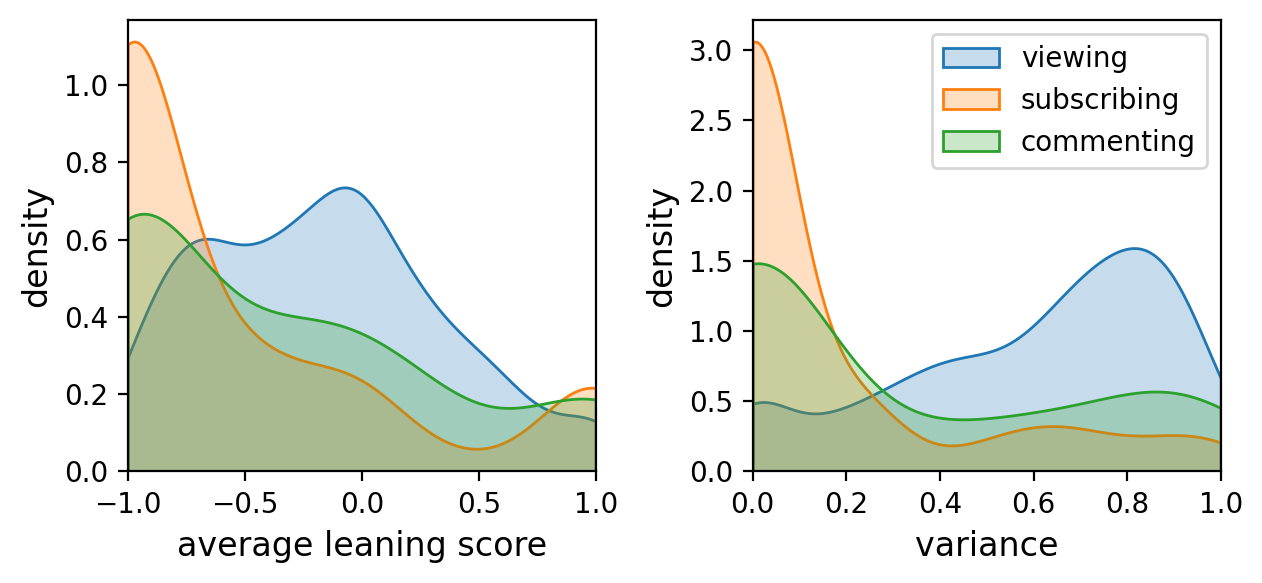

In [22]:
import seaborn as sns
fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
sns.kdeplot(view_aggr["view_score"], label="viewing", fill=True, ax=axes[0], cut=0)
sns.kdeplot(subscribe_aggr["subscribe_score"], label="subsribing", fill=True, ax=axes[0], cut=0)
sns.kdeplot(comment_aggr["comment_score"], label="commenting", fill=True, ax=axes[0], cut=0)

axes[0].set_xlim(-1, 1)
axes[0].set_xlabel("average leaning score", fontsize=12)
axes[0].set_ylabel("density", fontsize=12)
axes[1].set_ylabel("density", fontsize=12)
# axes[0].legend()

sns.kdeplot(view_aggr["view_var"], label="viewing", fill=True, ax=axes[1], cut=0)
sns.kdeplot(subscribe_aggr["subscribe_var"], label="subscribing", fill=True, ax=axes[1], cut=0)
sns.kdeplot(comment_aggr["comment_var"], label="commenting", fill=True, ax=axes[1], cut=0)
axes[1].set_xlabel("variance", fontsize=12)
axes[1].set_xlim(0, 1)
axes[1].legend()
plt.tight_layout()
# plt.savefig(OUTPATH + "engage-avg-leaning-var.pdf", dpi=300, bbox_inches="tight")

### Appendix Figure 18 
Average leaning score (left) and the leaning variance (right) for the Hungarian
political content the respondents have engaged with through viewing, subscribing or
commenting. Here we present the result generated from the same group of respondents
who have engaged in all three forms. 

57


Text(0.5, 1.08, 'For the same group of respondents (N = 57)')

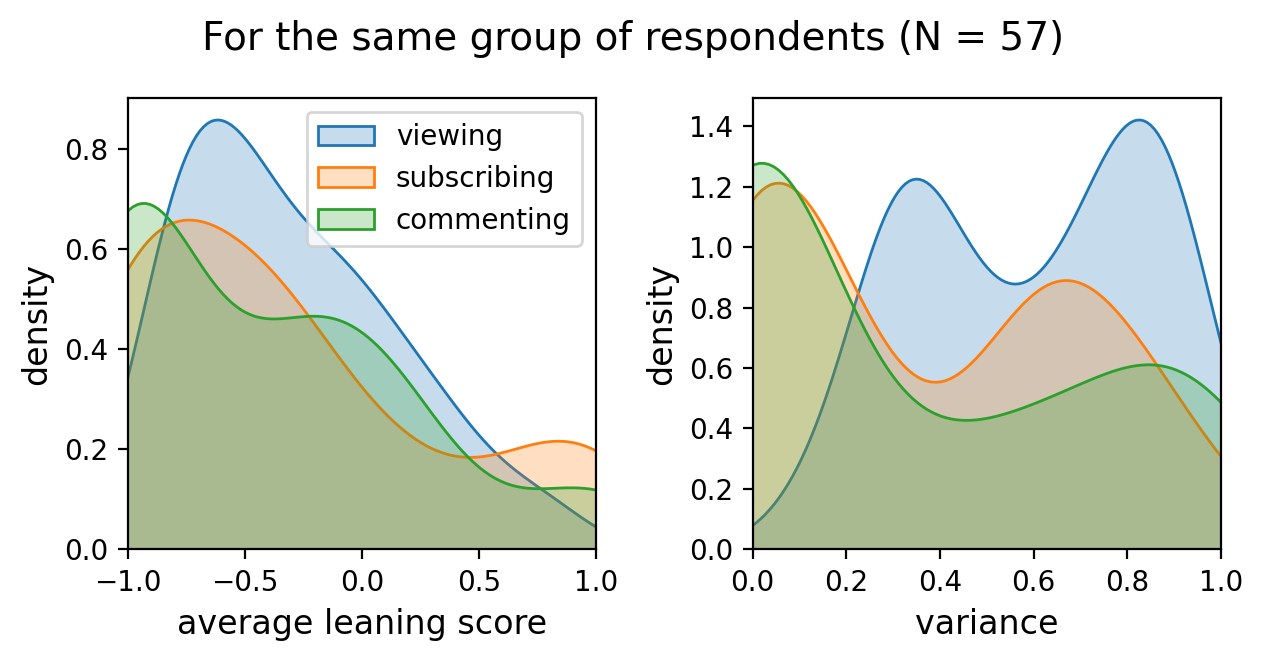

In [23]:
# # if filtering for the same user group
uvsc = uv.intersection(us).intersection(uc)
print(len(uvsc))

import seaborn as sns

fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
sns.kdeplot(view_aggr[view_aggr["respondent_id"].isin(uvsc)]["view_score"], label="viewing", fill=True, ax=axes[0])
sns.kdeplot(subscribe_aggr[subscribe_aggr["respondent_id"].isin(uvsc)]["subscribe_score"], label="subscribing", fill=True, ax=axes[0])
sns.kdeplot(comment_aggr[comment_aggr["respondent_id"].isin(uvsc)]["comment_score"], label="commenting", fill=True, ax=axes[0])

axes[0].set_xlim(-1, 1)
axes[0].set_xlabel("average leaning score", fontsize=12)
axes[0].set_ylabel("density", fontsize=12)
axes[1].set_ylabel("density", fontsize=12)
# axes[0].legend()

sns.kdeplot(view_aggr[view_aggr["respondent_id"].isin(uvsc)]["view_var"], label="viewing", fill=True, ax=axes[1])
sns.kdeplot(subscribe_aggr[subscribe_aggr["respondent_id"].isin(uvsc)]["subscribe_var"], label="subscribing", fill=True, ax=axes[1])
sns.kdeplot(comment_aggr[comment_aggr["respondent_id"].isin(uvsc)]["comment_var"], label="commenting", fill=True, ax=axes[1])
axes[1].set_xlabel("variance", fontsize=12)
axes[1].set_xlim(0, 1)
axes[0].legend()
plt.tight_layout()
plt.suptitle("For the same group of respondents (N = 57)", fontsize=14, y=1.08)
# plt.savefig(OUTPATH + "engage-avg-leaning-var-same-group.pdf", dpi=300, bbox_inches="tight")

## KS-Test to compare distributions of variance/kurtosis for left/right, anti-/pro-gov variables - Table 6

(note that the bootstrapping process have small fluctuations in each round, but it won't impact our main conclusions in the paper)

In [24]:
from scipy.stats import mannwhitneyu

nruns2 = 200
Us_lrsc_var = {}
ps_lrsc_var = {}
Us_lrsc_kts = {}
ps_lrsc_kts = {}

Us_flth_var = {}
ps_flth_var = {}
Us_flth_kts = {}
ps_flth_kts = {}

GROUPS_TO_COMPARE = [
    ("ALL", "YTB"),
    ("ALL", "POL"),
    ("ALL", "POL-HU"),
    ("YTB", "POL"),
    ("YTB", "POL-HU"),
    ("POL", "POL-HU"),
    ("VIEW", "SBSC"),
    ("VIEW", "CMNT"),
    ("SBSC", "CMNT"),
]
for g1,g2 in GROUPS_TO_COMPARE:
    for Us in [Us_flth_var, Us_flth_kts, Us_lrsc_var, Us_lrsc_kts]:
        Us[(g1,g2)] = []
    for ps in [ps_flth_var, ps_flth_kts, ps_lrsc_var, ps_lrsc_kts]:
        ps[(g1,g2)] = []

for r2 in range(nruns2):
    if r2%20 == 0: print("run:", r2, "progress:", r2/nruns2)
    nruns = 200
    bp_data_flth_var = {}
    bp_data_lrsc_var = {}
    bp_data_flth_kts = {}
    bp_data_lrsc_kts = {}
    for u,lab in zip(UGROUPS_7, UGROUPS_LAB_7):
        sub_df = pol_df[pol_df["respondent_id"].isin(u)]
        var_ls_flth = []
        var_ls_lrsc = []
        kts_ls_flth = []
        kts_ls_lrsc = []
        for r in range(nruns):
            sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
            var_ls_flth.append(compute_variance(sub_df_resample["feel_thm_fdsz"].tolist()))
            var_ls_lrsc.append(compute_variance(sub_df_resample["lftRght"].tolist()))
            kts_ls_flth.append(compute_kurtosis(sub_df_resample["feel_thm_fdsz"].tolist()))
            kts_ls_lrsc.append(compute_kurtosis(sub_df_resample["lftRght"].tolist()))
        bp_data_flth_var[lab] = var_ls_flth
        bp_data_lrsc_var[lab] = var_ls_lrsc
        bp_data_flth_kts[lab] = kts_ls_flth
        bp_data_lrsc_kts[lab] = kts_ls_lrsc
        
    for g1,g2 in GROUPS_TO_COMPARE:
        for data, Us, ps in zip(
            [bp_data_flth_var, bp_data_flth_kts, bp_data_lrsc_var, bp_data_lrsc_kts],
            [Us_flth_var, Us_flth_kts, Us_lrsc_var, Us_lrsc_kts],
            [ps_flth_var, ps_flth_kts, ps_lrsc_var, ps_lrsc_kts]):
            
            U, p = mannwhitneyu(data[g1], data[g2], method="asymptotic")
            Us[(g1,g2)].append(U)
            ps[(g1,g2)].append(p)

run: 0 progress: 0.0
run: 20 progress: 0.1
run: 40 progress: 0.2
run: 60 progress: 0.3
run: 80 progress: 0.4
run: 100 progress: 0.5
run: 120 progress: 0.6
run: 140 progress: 0.7
run: 160 progress: 0.8
run: 180 progress: 0.9


In [33]:
# Table 6 - chunk 1: left/right variance distribution
df = pd.DataFrame()
df["sample1"] = [x[0] for x in GROUPS_TO_COMPARE]
df["sample2"] = [x[1] for x in GROUPS_TO_COMPARE]

Us = Us_lrsc_var
ps = ps_lrsc_var

ciu = []
cip = []
pps = []
for g1,g2 in GROUPS_TO_COMPARE:
    this_us = Us[(g1,g2)]
    this_ps = ps[(g1,g2)]
    bu = round(np.percentile(this_us, q=5),1)
    uu = round(np.percentile(this_us, q=95),1)
    bp = round(np.percentile(this_ps, q=5),2)
    up = round(np.percentile(this_ps, q=95),2)
    pp = sum(p < 0.05 for p in this_ps)/nruns2*100
    ciu.append(f"[{bu}, {uu}]")
    cip.append(f"[{bp}, {up}]")
    pps.append(pp)
df["CIU"] = ciu 
df["CIP"] = cip
df["power"] = pps
df

,sample1,sample2,CIU,CIP,power
0,ALL,YTB,"[19106.4, 22668.3]","[0.02, 0.89]",10.0
1,ALL,POL,"[19650.6, 22991.0]","[0.01, 0.89]",21.5
2,ALL,POL-HU,"[22733.3, 26180.1]","[0.0, 0.02]",97.5
3,YTB,POL,"[18578.8, 22406.7]","[0.03, 0.92]",8.0
4,YTB,POL-HU,"[21357.3, 25349.2]","[0.0, 0.24]",88.0
5,POL,POL-HU,"[21012.9, 24889.7]","[0.0, 0.38]",72.0
6,VIEW,SBSC,"[19719.8, 23529.0]","[0.0, 0.89]",23.5
7,VIEW,CMNT,"[3747.8, 6008.0]","[0.0, 0.0]",100.0
8,SBSC,CMNT,"[3839.1, 5996.3]","[0.0, 0.0]",100.0


In [34]:
# Table 6 - chunk 2: left/right kurtosis distribution
df = pd.DataFrame()
df["sample1"] = [x[0] for x in GROUPS_TO_COMPARE]
df["sample2"] = [x[1] for x in GROUPS_TO_COMPARE]

Us = Us_lrsc_kts
ps = ps_lrsc_kts

ciu = []
cip = []
pps = []
for g1,g2 in GROUPS_TO_COMPARE:
    this_us = Us[(g1,g2)]
    this_ps = ps[(g1,g2)]
    bu = round(np.percentile(this_us, q=5),1)
    uu = round(np.percentile(this_us, q=95),1)
    bp = round(np.percentile(this_ps, q=5),2)
    up = round(np.percentile(this_ps, q=95),2)
    pp = sum(p < 0.05 for p in this_ps)/nruns2*100
    ciu.append(f"[{bu}, {uu}]")
    cip.append(f"[{bp}, {up}]")
    pps.append(pp)
df["CIU"] = ciu 
df["CIP"] = cip
df["power"] = pps
df

,sample1,sample2,CIU,CIP,power
0,ALL,YTB,"[16701.2, 20069.6]","[0.0, 0.8]",26.5
1,ALL,POL,"[16538.7, 19973.6]","[0.0, 0.77]",27.5
2,ALL,POL-HU,"[12831.3, 15957.2]","[0.0, 0.0]",99.5
3,YTB,POL,"[18081.4, 21847.4]","[0.07, 0.95]",3.5
4,YTB,POL-HU,"[14162.6, 17496.6]","[0.0, 0.03]",96.0
5,POL,POL-HU,"[13997.4, 17885.9]","[0.0, 0.07]",93.5
6,VIEW,SBSC,"[25549.6, 29051.2]","[0.0, 0.0]",100.0
7,VIEW,CMNT,"[34703.6, 36837.4]","[0.0, 0.0]",100.0
8,SBSC,CMNT,"[32500.4, 34987.2]","[0.0, 0.0]",100.0


In [35]:
# Table 6 - chunk 3: anti-/pro-gov variance distribution
df = pd.DataFrame()
df["sample1"] = [x[0] for x in GROUPS_TO_COMPARE]
df["sample2"] = [x[1] for x in GROUPS_TO_COMPARE]

Us = Us_flth_var
ps = ps_flth_var

ciu = []
cip = []
pps = []
for g1,g2 in GROUPS_TO_COMPARE:
    this_us = Us[(g1,g2)]
    this_ps = ps[(g1,g2)]
    bu = round(np.percentile(this_us, q=5),1)
    uu = round(np.percentile(this_us, q=95),1)
    bp = round(np.percentile(this_ps, q=5),2)
    up = round(np.percentile(this_ps, q=95),2)
    pp = sum(p < 0.05 for p in this_ps)/nruns2*100
    ciu.append(f"[{bu}, {uu}]")
    cip.append(f"[{bp}, {up}]")
    pps.append(pp)
df["CIU"] = ciu 
df["CIP"] = cip
df["power"] = pps
df

,sample1,sample2,CIU,CIP,power
0,ALL,YTB,"[15545.6, 18945.7]","[0.0, 0.36]",66.0
1,ALL,POL,"[13905.6, 18097.1]","[0.0, 0.1]",93.0
2,ALL,POL-HU,"[20601.6, 23912.8]","[0.0, 0.6]",50.0
3,YTB,POL,"[16838.8, 20510.6]","[0.01, 0.89]",23.0
4,YTB,POL-HU,"[23293.4, 26780.1]","[0.0, 0.0]",98.0
5,POL,POL-HU,"[24195.4, 27632.6]","[0.0, 0.0]",100.0
6,VIEW,SBSC,"[22189.4, 25894.4]","[0.0, 0.06]",93.0
7,VIEW,CMNT,"[1089.6, 2504.6]","[0.0, 0.0]",100.0
8,SBSC,CMNT,"[1085.6, 2319.4]","[0.0, 0.0]",100.0


In [36]:
# Table 6 - chunk 4: anti-/pro-gov kurtosis distribution
df = pd.DataFrame()
df["sample1"] = [x[0] for x in GROUPS_TO_COMPARE]
df["sample2"] = [x[1] for x in GROUPS_TO_COMPARE]

Us = Us_flth_kts
ps = ps_flth_kts

ciu = []
cip = []
pps = []
for g1,g2 in GROUPS_TO_COMPARE:
    this_us = Us[(g1,g2)]
    this_ps = ps[(g1,g2)]
    bu = round(np.percentile(this_us, q=5),1)
    uu = round(np.percentile(this_us, q=95),1)
    bp = round(np.percentile(this_ps, q=5),2)
    up = round(np.percentile(this_ps, q=95),2)
    pp = sum(p < 0.05 for p in this_ps)/nruns2*100
    ciu.append(f"[{bu}, {uu}]")
    cip.append(f"[{bp}, {up}]")
    pps.append(pp)
df["CIU"] = ciu 
df["CIP"] = cip
df["power"] = pps
df

,sample1,sample2,CIU,CIP,power
0,ALL,YTB,"[19865.3, 23623.4]","[0.0, 0.88]",32.0
1,ALL,POL,"[18361.2, 22271.2]","[0.04, 0.94]",7.5
2,ALL,POL-HU,"[12770.8, 16268.9]","[0.0, 0.0]",100.0
3,YTB,POL,"[16635.5, 20729.8]","[0.0, 0.84]",20.0
4,YTB,POL-HU,"[11342.6, 14931.4]","[0.0, 0.0]",100.0
5,POL,POL-HU,"[12485.8, 16440.7]","[0.0, 0.0]",100.0
6,VIEW,SBSC,"[4621.0, 7042.3]","[0.0, 0.0]",100.0
7,VIEW,CMNT,"[35405.4, 37324.0]","[0.0, 0.0]",100.0
8,SBSC,CMNT,"[38050.0, 39189.2]","[0.0, 0.0]",100.0
